# Overview
This notebook is used to tune the parameters needed for dbscan (epsilon and min_samples) and will plot the trajectories in a specified cluster. 

This notebook expects the AIS data stored as pickle files so before running this notebook, ensure that the AIS data has been cleaned and split into a train, test and validation .pkl files. To ensure the correct file compatibility, please run `csv2pkl_optimized.py` and `data_prep_v2.py` to preprocess the data before running this notebook. 

**Note**
If you're working with large amounts of data, please consider running the python files in a high performance computing environment

In [24]:
# inports
import os
import math
import numpy as np
import pickle
import pandas as pd
from sktime.clustering.dbscan import TimeSeriesDBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

The code block below will arrange the data in a way that is suitable for clustering.

It will create a `numpy.ndarray` of shape: 

`(number of samples, sequence length, number of features)`


In [ ]:
# Set data directory and phases
# This path should be changed to the location of your data
vessel_type = 'tankers_and_cargo'  # Options: 'fishing', 'passenger', etc.
data_dir = f'/home/chucey/GQP/TrAISformer/data/US_data/cleaned_data/{vessel_type}/'
# phases = ['train', 'test', 'valid']
phases =['test']

# First pass: collect all lengths to calculate 95th percentile
all_lengths = []
arrays_to_stack = []
phase_lengths = []

for phase in phases:
    with open(os.path.join(data_dir, f'us_continent_2024_{phase}_track.pkl'), 'rb') as f:
        data = pickle.load(f)
    phase_lengths.append((phase, len(data)))
    
    # Get the trajectories from each phase and take first 4 features
    for idx in range(len(data)):

        phase_array = data[idx]['traj'][:, :4]
        arrays_to_stack.append(phase_array)
        all_lengths.append(phase_array.shape[0])
        # print(f"{phase} original shape: {phase_array.shape}")

# Calculate 95th percentile as target length
target_length = int(np.percentile(all_lengths, 95))
# print(f"\nLengths: {all_lengths}")
print(f"95th percentile target length: {target_length}")

# Process each array to have exactly the target length
processed_arrays = []
for i, arr in enumerate(arrays_to_stack):
    current_length = arr.shape[0]
    
    if current_length > target_length:
        # Truncate to target length
        processed = arr[:target_length, :]
        # print(f"{phases[i]} truncated from {current_length} to {target_length}")
    elif current_length < target_length:
        # Pad with zeros to reach target length
        padding_needed = target_length - current_length
        padding = np.zeros((padding_needed, arr.shape[1]))
        processed = np.vstack([arr, padding])
        # print(f"{phases[i]} padded from {current_length} to {target_length}")
    else:
        # Already exactly target length
        processed = arr
        # print(f"{phases[i]} already {target_length} length")
    
    processed_arrays.append(processed)
    # print(f"{phases[i]} final shape: {processed.shape}")

# Stack all arrays to get shape (3, target_length, 4)
stacked_array = np.stack(processed_arrays, axis=0)
print(f"\nStacked array shape: {stacked_array.shape}")

X = stacked_array

95th percentile target length: 144

Stacked array shape: (13828, 144, 4)


In [ ]:
def cluster(X, eps, min_samples, distance_metric):
    '''Performs DBSCAN clustering on the provided data X with specified parameters.'''
    dbscan = TimeSeriesDBSCAN(eps=eps, min_samples=min_samples, distance=distance_metric, n_jobs=-1)
    dbscan.fit(X)
    labels = dbscan.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    n_samples = X.shape[0]
    
    # Silhouette score requires at least 2 clusters
    sil_score = silhouette_score(X.reshape(n_samples, -1), labels) if n_clusters > 1 else None
    
    return {
        'eps': eps,
        'min_samples': min_samples,
        'distance': distance_metric,
        'n_clusters': n_clusters,
        'labels': labels,
        'n_noise': n_noise,
        'silhouette_score': sil_score,
    }

def evaluate_clustering(X, labels, metric_name=""):
    """
    Comprehensive evaluation of clustering results for time series data
    """
    print(f"\n{metric_name} Clustering Evaluation:")
    print("-" * 40)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    n_samples = len(labels)
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise} ({n_noise/n_samples*100:.1f}%)")
    print(f"Number of clustered points: {n_samples - n_noise} ({(n_samples-n_noise)/n_samples*100:.1f}%)")
    
    if n_clusters > 1 and n_noise < n_samples:
        # Only calculate metrics if we have meaningful clusters
        X_flat = X.reshape(X.shape[0], -1)
        
        # Remove noise points for internal metrics
        non_noise_mask = labels != -1
        if np.sum(non_noise_mask) > 0:
            X_clean = X_flat[non_noise_mask]
            labels_clean = labels[non_noise_mask]
            
            if len(set(labels_clean)) > 1:
                # Calinski-Harabasz Index (higher is better)
                ch_score = calinski_harabasz_score(X_clean, labels_clean)
                print(f"Calinski-Harabasz Index: {ch_score:.3f} (higher = better)")
                
                # Davies-Bouldin Index (lower is better)
                db_score = davies_bouldin_score(X_clean, labels_clean)
                print(f"Davies-Bouldin Index: {db_score:.3f} (lower = better)")
                
                # Silhouette Score (for comparison)
                sil_score = silhouette_score(X_clean, labels_clean)
                print(f"Silhouette Score: {sil_score:.3f} (higher = better)")
        
        # Cluster size distribution
        unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
        print(f"Cluster sizes: {dict(zip(unique_labels, counts))}")
        
        # Assess cluster balance
        if len(counts) > 0:
            size_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
            print(f"Cluster size ratio (max/min): {size_ratio:.2f} (closer to 1 = more balanced)")
    
    else:
        print("Cannot calculate internal metrics: insufficient clusters or all points are noise")
    
    return {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise/n_samples,
        'n_samples': n_samples,
        'Calinski-Harabasz': ch_score if n_clusters > 1 and n_noise < n_samples else None,
        'Davies-Bouldin': db_score if n_clusters > 1 and n_noise < n_samples else None,
        'size_ratio': size_ratio
    }

def find_best_text_position(longitudes, latitudes, figure_width=10, figure_height=6):
    """
    Find the best position for text box on plots to avoid data overlap and visual elements
    Returns (x, y, ha, va) coordinates and alignment
    """
    # Normalize coordinates to [0,1] range for plot positioning
    lon_range = longitudes.max() - longitudes.min()
    lat_range = latitudes.max() - latitudes.min()
    
    if lon_range == 0 or lat_range == 0:
        return 0.02, 0.98, 'left', 'top'  # Default to top-left if no range
    
    lon_norm = (longitudes - longitudes.min()) / lon_range
    lat_norm = (latitudes - latitudes.min()) / lat_range
    
    # Define candidate positions - AVOID COLORBAR AREA (right edge)
    # Prioritize corners and edges that are less likely to have data
    # Adjusted positions for LARGER text boxes with speed + COG information
    candidates = [
        (0.02, 0.98, 'left', 'top'),     # top-left (preferred)
        (0.02, 0.02, 'left', 'bottom'),  # bottom-left
        (0.25, 0.98, 'left', 'top'),     # top-left-center (moved closer to left)
        (0.25, 0.02, 'left', 'bottom'),  # bottom-left-center (moved closer to left)
        (0.45, 0.98, 'center', 'top'),   # top-center (moved left to avoid colorbar)
        (0.45, 0.02, 'center', 'bottom'), # bottom-center (moved left)
        (0.65, 0.98, 'right', 'top'),    # top-right-center (moved further left)
        (0.65, 0.02, 'right', 'bottom'), # bottom-right-center (moved further left)
        (0.02, 0.50, 'left', 'center'),  # middle-left
        (0.65, 0.50, 'right', 'center'), # middle-right (moved further left)
        (0.02, 0.75, 'left', 'top'),     # upper-left-middle (new position)
        (0.02, 0.25, 'left', 'bottom')   # lower-left-middle (new position)
    ]
    
    best_position = candidates[0]  # default to top-left
    min_score = float('inf')
    
    # Check each candidate position
    for x, y, ha, va in candidates:
        # Define text box region with accurate sizing for LARGER boxes (speed + COG stats)
        # Text now includes: Speed range, Avg speed, Mean COG, COG Std - requiring more space
        if ha == 'right':
            box_x_min, box_x_max = x - 0.18, x  # Increased from 0.12 to 0.18 for wider text
        elif ha == 'left':
            box_x_min, box_x_max = x, x + 0.18  # Increased width
        else:  # center
            box_x_min, box_x_max = x - 0.09, x + 0.09  # Increased from 0.06 to 0.09
            
        if va == 'top':
            box_y_min, box_y_max = y - 0.10, y  # Increased from 0.06 to 0.10 for taller text
        elif va == 'bottom':
            box_y_min, box_y_max = y, y + 0.10  # Increased height for 4-5 lines of text
        else:  # center
            box_y_min, box_y_max = y - 0.05, y + 0.05  # Increased from 0.03 to 0.05
        
        # Count data points that would overlap with text box
        overlap_count = np.sum(
            (lon_norm >= box_x_min) & (lon_norm <= box_x_max) &
            (lat_norm >= box_y_min) & (lat_norm <= box_y_max)
        )
        
        # Calculate data density in nearby regions (penalize crowded areas)
        # Increased margin to account for larger text boxes
        extended_margin = 0.08  # Increased from 0.05 to 0.08 for larger clearance
        extended_x_min = max(0, box_x_min - extended_margin)
        extended_x_max = min(1, box_x_max + extended_margin)
        extended_y_min = max(0, box_y_min - extended_margin)
        extended_y_max = min(1, box_y_max + extended_margin)
        
        nearby_count = np.sum(
            (lon_norm >= extended_x_min) & (lon_norm <= extended_x_max) &
            (lat_norm >= extended_y_min) & (lat_norm <= extended_y_max)
        )
        
        # Calculate trajectory path density (avoid dense trajectory areas)
        trajectory_density = 0
        if len(longitudes) > 1:
            # Check how many trajectory segments pass near this position
            for i in range(len(longitudes) - 1):
                seg_lon = [lon_norm[i], lon_norm[i+1]]
                seg_lat = [lat_norm[i], lat_norm[i+1]]
                
                # Simple check if segment intersects text box region
                if (min(seg_lon) <= box_x_max and max(seg_lon) >= box_x_min and
                    min(seg_lat) <= box_y_max and max(seg_lat) >= box_y_min):
                    trajectory_density += 1
        
        # Penalty for being too close to right edge (colorbar area)
        colorbar_penalty = max(0, (x - 0.75) * 10) if x > 0.75 else 0
        
        # Combined score: prioritize positions with less overlap, density, and trajectory interference
        score = (overlap_count * 3 +           # Direct overlap is worst
                nearby_count * 0.5 +           # Nearby density matters less
                trajectory_density * 2 +       # Trajectory interference
                colorbar_penalty)              # Avoid colorbar area
        
        if score < min_score:
            min_score = score
            best_position = (x, y, ha, va)
    
    return best_position

def add_course_arrows(ax, longitudes, latitudes, cog_degrees, spacing=8, arrow_scale=None):
    """
    Add directional arrows to show Course Over Ground with improved visibility
    
    Parameters:
    - spacing: Show arrow every N points to avoid clutter
    - arrow_scale: Size of arrows relative to data range (auto-calculated if None)
    """
    if len(longitudes) == 0 or len(cog_degrees) == 0:
        return
    
    # Auto-calculate arrow scale based on data range - LARGER ARROWS
    if arrow_scale is None:
        lon_range = np.max(longitudes) - np.min(longitudes)
        lat_range = np.max(latitudes) - np.min(latitudes)
        arrow_scale = min(lon_range, lat_range) * 0.035  # Increased from 0.02 to 0.035
    
    # Convert COG from degrees to radians
    # COG is measured clockwise from North (0° = North, 90° = East, etc.)
    cog_radians = np.radians(cog_degrees)
    
    # Calculate arrow components 
    # In matplotlib: dx = East component, dy = North component
    dx = arrow_scale * np.sin(cog_radians)   # East component
    dy = arrow_scale * np.cos(cog_radians)  # North component

    # Sample points to avoid overcrowding
    indices = range(0, len(longitudes), spacing)
    
    for i in indices:
        if i < len(longitudes) and not (np.isnan(dx[i]) or np.isnan(dy[i])):
            # Calculate smart offset to avoid overlapping with data points
            # Offset perpendicular to the trajectory direction for better visibility
            offset_scale = arrow_scale * 0.9  # Smaller offset relative to arrow size
            
            # Calculate perpendicular offset (90 degrees to COG direction)
            perpendicular_angle = cog_radians[i] + np.pi/2
            offset_x = offset_scale * np.sin(perpendicular_angle)
            offset_y = offset_scale * np.cos(perpendicular_angle)
            
            # Position arrow slightly offset from the data point
            arrow_x = longitudes[i] + offset_x
            arrow_y = latitudes[i] + offset_y
            
            # IMPROVED ARROW VISIBILITY - positioned to avoid data point overlap
            ax.arrow(arrow_x, arrow_y, dx[i], dy[i],
                    head_width=arrow_scale*0.5, head_length=arrow_scale*0.4,
                    fc='red', ec='darkred', alpha=0.9, length_includes_head=True,
                    linewidth=2.0, zorder=10)  # Higher zorder to appear on top

def add_cog_statistics_text(ax, cog_degrees, text_x, text_y, h_align, v_align):
    """Add COG statistics to the existing text box"""
    # Calculate COG statistics
    cog_mean = np.nanmean(cog_degrees)
    cog_std = np.nanstd(cog_degrees)
    
    # Convert mean direction to cardinal direction
    def degrees_to_cardinal(deg):
        directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                     'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
        idx = int((deg + 11.25) / 22.5) % 16
        return directions[idx]
    
    cardinal = degrees_to_cardinal(cog_mean)
    
    return f'Mean COG: {cog_mean:.0f}° ({cardinal})\nCOG Std: {cog_std:.0f}°'

def remove_trailing_padding(arr: np.ndarray) -> np.ndarray:
    # Identify rows that are not all zeros
    non_zero_rows = np.any(arr != 0, axis=1)
    if not np.any(non_zero_rows):
        # If all rows are zeros, return empty array
        return arr[:0]
    
    # Find the index of the last non-zero row
    last_non_zero_idx = np.where(non_zero_rows)[0][-1]
    
    # Return array up to and including the last non-zero row
    return arr[:last_non_zero_idx + 1]

def denormalize_coordinates(coordinates:np.ndarray) -> np.ndarray:
    lat = coordinates[:, 0] * (lat_max - lat_min) + lat_min
    lon = coordinates[:, 1] * (lon_max - lon_min) + lon_min
    sog = coordinates[:, 2] * max_sog  # speed over ground
    cog = coordinates[:, 3] * max_cog  # course over ground
    return np.column_stack((lat, lon, sog, cog))

def plot_pca(X:np.ndarray, labels:np.ndarray):
    X_flattened = X.reshape(X.shape[0], -1)
    # Apply PCA to reduce to 3 components for 3D visualization
    sklearn_pca_3d = PCA(n_components=3, random_state=42)
    X_pca_3d = sklearn_pca_3d.fit_transform(X_flattened)

    print(f"3D PCA shape: {X_pca_3d.shape}")
    print(f"3D Explained variance ratio: {sklearn_pca_3d.explained_variance_ratio_}")
    print(f"3D Total explained variance: {sklearn_pca_3d.explained_variance_ratio_.sum():.3f}")

    # Create 3D plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get unique labels for color mapping
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Create color map
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    label_to_color = dict(zip(unique_labels, colors))

    # Plot each cluster separately for better legend
    for label in unique_labels:
        mask = labels == label
        cluster_points = X_pca_3d[mask]
        
        if label == -1:
            # Plot noise points differently
            scatter = ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                            c='gray', alpha=0.4, s=20, label=f'Noise ({mask.sum()} points)')
        else:
            # Plot cluster points
            scatter = ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                            c=[label_to_color[label]], alpha=0.7, s=50, 
                            label=f'Cluster {label} ({mask.sum()} points)')
            
            # Add cluster center annotation
            # center = cluster_points.mean(axis=0)
            # ax.text(center[0], center[1], center[2], f'C{label}', 
            #        fontsize=12, fontweight='bold', 
            #        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Set labels with variance information
    ax.set_xlabel(f'PC1 ({sklearn_pca_3d.explained_variance_ratio_[0]:.1%} variance)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC2 ({sklearn_pca_3d.explained_variance_ratio_[1]:.1%} variance)', fontsize=12, fontweight='bold')
    ax.set_zlabel(f'PC3 ({sklearn_pca_3d.explained_variance_ratio_[2]:.1%} variance)', fontsize=12, fontweight='bold')

    # Title and styling
    ax.set_title(f'3D PCA Visualization of Trajectory Clusters of {vessel_type.upper()} Vessels\n(3D projection of time series data)', 
                fontsize=16, fontweight='bold', pad=20)

    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))

    # Add grid
    ax.grid(True, alpha=0.3)

    # Set viewing angle for better visualization
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

    # Print detailed 3D PCA analysis
    print(f"\n3D PCA Analysis Summary:")
    print(f"- Original dimensionality: {X_flattened.shape[1]} features")
    print(f"- Reduced to: 3 components")
    print(f"- Information preserved: {sklearn_pca_3d.explained_variance_ratio_.sum():.1%}")
    print(f"- PC1 explains {sklearn_pca_3d.explained_variance_ratio_[0]:.1%} of variance")
    print(f"- PC2 explains {sklearn_pca_3d.explained_variance_ratio_[1]:.1%} of variance")
    print(f"- PC3 explains {sklearn_pca_3d.explained_variance_ratio_[2]:.1%} of variance")

    # Cluster separation analysis in 3D
    print(f"\nCluster Separation Analysis:")
    for label in unique_labels:
        if label != -1:
            cluster_points = X_pca_3d[labels == label]
            center = cluster_points.mean(axis=0)
            std = cluster_points.std(axis=0)
            print(f"Cluster {label}: Center=({center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f}), "
                f"Spread=({std[0]:.2f}, {std[1]:.2f}, {std[2]:.2f})")

In [4]:
print("\n" + "="*60)
print("EVALUATION METRICS GUIDE:")
print("="*60)
print("✓ Calinski-Harabasz Index: Ratio of between-cluster to within-cluster variance")
print("  - Higher values indicate better defined clusters")
print("  - Good for comparing different parameter settings")
print("\n✓ Davies-Bouldin Index: Average similarity between clusters")
print("  - Lower values indicate better separated clusters")
print("  - Considers both cluster separation and compactness")
print("\n✓ Cluster Balance: Size ratio between largest and smallest clusters")
print("  - Values close to 1 indicate well-balanced clusters")
print("  - Very high ratios might indicate parameter tuning needed")
print("\n✓ Noise Ratio: Percentage of points classified as noise")
print("  - For vessel trajectories, 10-30% noise might be reasonable")
print("  - Very high noise ratios suggest eps is too small")
print("="*60)


EVALUATION METRICS GUIDE:
✓ Calinski-Harabasz Index: Ratio of between-cluster to within-cluster variance
  - Higher values indicate better defined clusters
  - Good for comparing different parameter settings

✓ Davies-Bouldin Index: Average similarity between clusters
  - Lower values indicate better separated clusters
  - Considers both cluster separation and compactness

✓ Cluster Balance: Size ratio between largest and smallest clusters
  - Values close to 1 indicate well-balanced clusters
  - Very high ratios might indicate parameter tuning needed

✓ Noise Ratio: Percentage of points classified as noise
  - For vessel trajectories, 10-30% noise might be reasonable
  - Very high noise ratios suggest eps is too small


In [5]:
# Create a results file to log results and plot results
entries = ('eps', 'min_samples', 'distance_metric', 'num_clusters', 'number_of_samples', 'num_clustered_points', 'num_noise', 'noise_ratio', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 'size_ratio')

with open('clustering_results.csv', 'w') as file:
    file.write(','.join(entries))
    file.write('\n')

In [ ]:
X = stacked_array
np.random.seed(42)
# use a sample of the data for speed
sample_size = min(500, X.shape[0])  # Use max 500 samples for speed
indices = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[indices]

# Parameter grid for DBSCAN
# adjust these ranges based on your data characteristics
eps_search = [15, 17]
min_samples_search = [10, 15]

for eps in eps_search:
    for min_samples in min_samples_search:
        print(f"\nClustering with eps={eps}, min_samples={min_samples} using DTW:")
        try:
            clustering_results = cluster(X_sample, eps=eps, min_samples=min_samples, distance_metric="dtw")
            results = evaluate_clustering(X_sample, clustering_results['labels'], f"DTW eps={eps} min_samples={min_samples}")
        except Exception as e:
            print(f"Error occurred: {e} - skipping this parameter set {eps}, {min_samples}.")
            continue
        print("="*60)
        print('Writing results to CSV...')
        data_entries = (clustering_results['eps'], clustering_results['min_samples'], clustering_results['distance'], results['n_clusters'], results['n_samples'], results['n_samples'] - results['n_noise'], results['n_noise'], results['noise_ratio'], results['Calinski-Harabasz'], results['Davies-Bouldin'], results['size_ratio'])
        with open('clustering_results.csv', 'a') as file:
            file.write(','.join(map(str, data_entries)))
            file.write('\n')
        print('entry written.')
        print("="*60)
print("\nAll parameter combinations evaluated and results saved to clustering_results.csv")




Clustering with eps=15, min_samples=10 using DTW:

DTW eps=15 min_samples=10 Clustering Evaluation:
----------------------------------------
Number of clusters: 3
Number of noise points: 266 (53.2%)
Number of clustered points: 234 (46.8%)
Calinski-Harabasz Index: 165.765 (higher = better)
Davies-Bouldin Index: 1.162 (lower = better)
Silhouette Score: 0.417 (higher = better)
Cluster sizes: {np.int64(0): np.int64(170), np.int64(1): np.int64(53), np.int64(2): np.int64(11)}
Cluster size ratio (max/min): 15.45 (closer to 1 = more balanced)
Writing results to CSV...
entry written.

Clustering with eps=15, min_samples=15 using DTW:

DTW eps=15 min_samples=15 Clustering Evaluation:
----------------------------------------
Number of clusters: 2
Number of noise points: 285 (57.0%)
Number of clustered points: 215 (43.0%)
Calinski-Harabasz Index: 300.383 (higher = better)
Davies-Bouldin Index: 0.678 (lower = better)
Silhouette Score: 0.543 (higher = better)
Cluster sizes: {np.int64(0): np.int64(5

In [7]:
df = pd.read_csv('clustering_results.csv')
df = df.drop_duplicates(subset=['eps', 'min_samples'])
df.sort_values(by=['eps', 'min_samples'], ascending=[True, True], inplace=True)
df.head()

,eps,min_samples,distance_metric,num_clusters,number_of_samples,num_clustered_points,num_noise,noise_ratio,Calinski-Harabasz Index,Davies-Bouldin Index,size_ratio
0,15,10,dtw,3,500,234,266,0.532,165.764636,1.161923,15.454545
1,15,15,dtw,2,500,215,285,0.570,300.383159,0.677676,3.056604
2,17,10,dtw,3,500,317,183,0.366,164.767758,1.366703,22.700000
3,17,15,dtw,3,500,279,221,0.442,170.882963,1.165923,17.583333


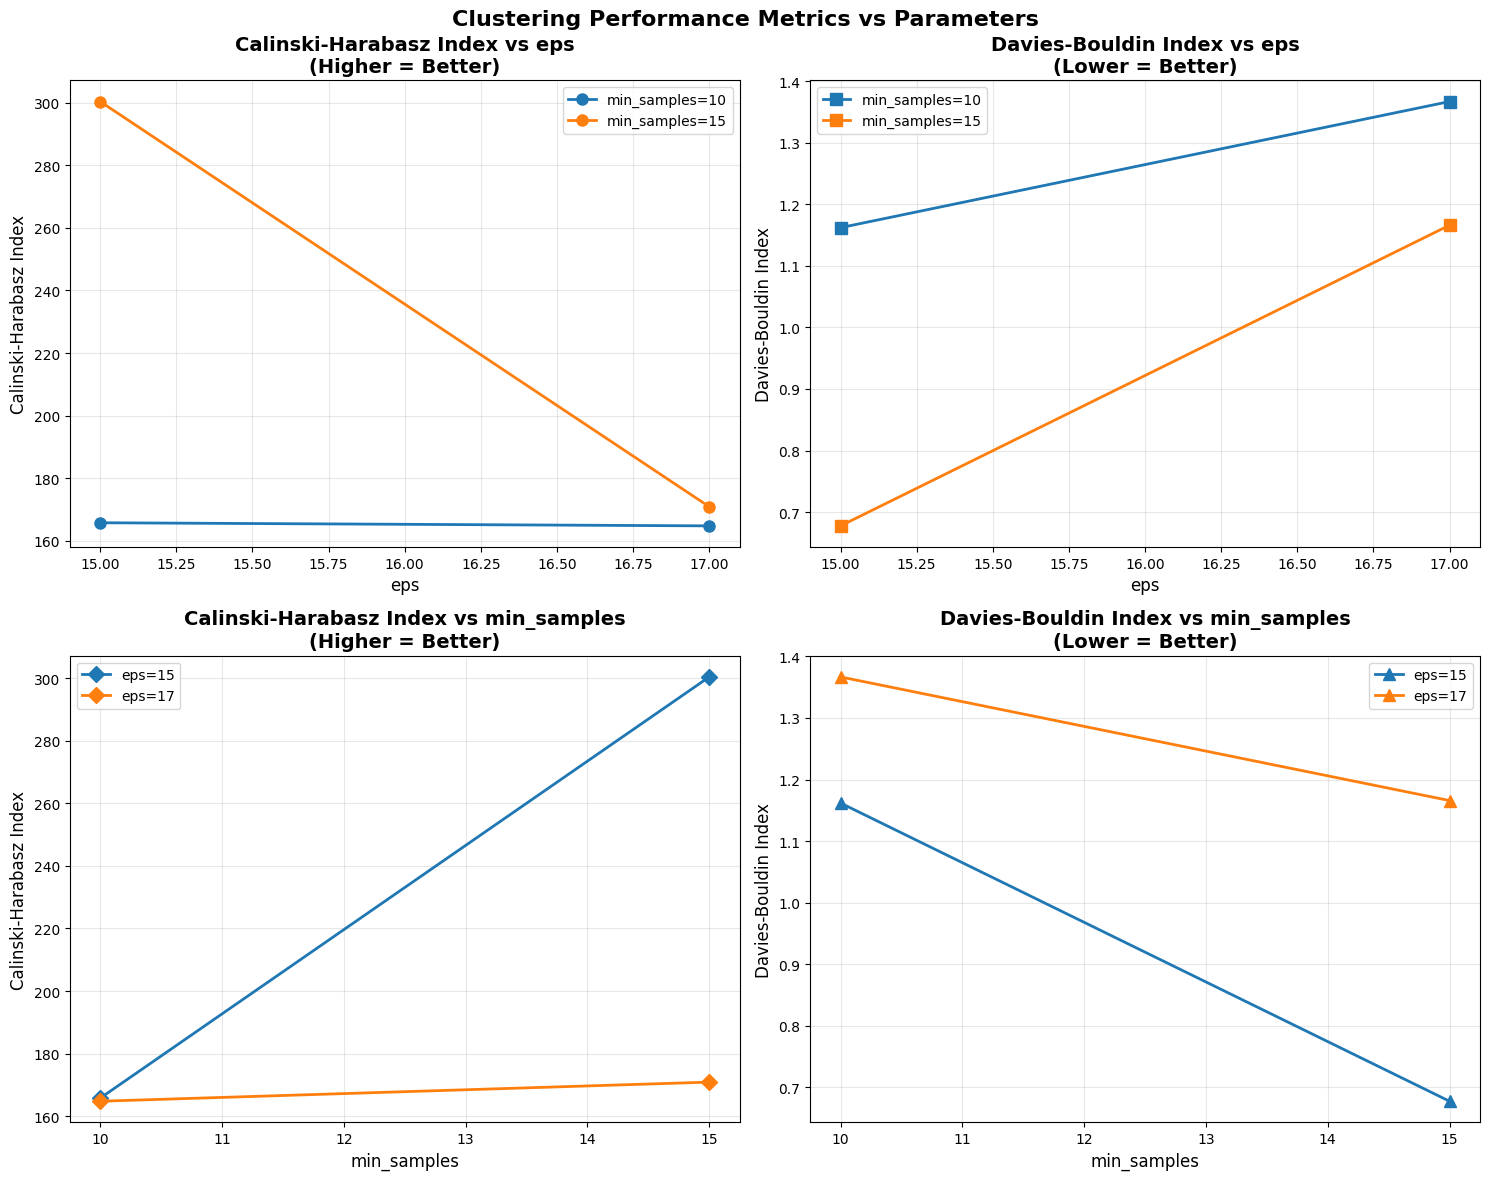

CLUSTERING PERFORMANCE SUMMARY

Best Calinski-Harabasz Index (Higher = Better):
eps=15, min_samples=15, CH Index=300.383

Best Davies-Bouldin Index (Lower = Better):
eps=15, min_samples=15, DB Index=0.678

Most Balanced Clusters (size_ratio closest to 1):
eps=15, min_samples=15, size_ratio=3.057

Lowest Noise Ratio:
eps=17, min_samples=10, noise_ratio=0.366

Choose the best combination of eps and min_samples based on your specific needs and trade-offs.


In [8]:
# Create subplots for both metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16, fontweight='bold')

# 1. Calinski-Harabasz Index vs eps (grouped by min_samples)
ax1 = axes[0, 0]
for min_samp in df['min_samples'].unique():
    subset = df[df['min_samples'] == min_samp]
    ax1.plot(subset['eps'], subset['Calinski-Harabasz Index'], 
             marker='o', linewidth=2, markersize=8, label=f'min_samples={min_samp}')
ax1.set_xlabel('eps', fontsize=12)
ax1.set_ylabel('Calinski-Harabasz Index', fontsize=12)
ax1.set_title('Calinski-Harabasz Index vs eps\n(Higher = Better)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Davies-Bouldin Index vs eps (grouped by min_samples)
ax2 = axes[0, 1]
for min_samp in df['min_samples'].unique():
    subset = df[df['min_samples'] == min_samp]
    ax2.plot(subset['eps'], subset['Davies-Bouldin Index'], 
             marker='s', linewidth=2, markersize=8, label=f'min_samples={min_samp}')
ax2.set_xlabel('eps', fontsize=12)
ax2.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax2.set_title('Davies-Bouldin Index vs eps\n(Lower = Better)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Calinski-Harabasz Index vs min_samples (grouped by eps)
ax3 = axes[1, 0]
for eps_val in df['eps'].unique():
    subset = df[df['eps'] == eps_val]
    ax3.plot(subset['min_samples'], subset['Calinski-Harabasz Index'], 
             marker='D', linewidth=2, markersize=8, label=f'eps={eps_val}')
ax3.set_xlabel('min_samples', fontsize=12)
ax3.set_ylabel('Calinski-Harabasz Index', fontsize=12)
ax3.set_title('Calinski-Harabasz Index vs min_samples\n(Higher = Better)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Davies-Bouldin Index vs min_samples (grouped by eps)
ax4 = axes[1, 1]
for eps_val in df['eps'].unique():
    subset = df[df['eps'] == eps_val]
    ax4.plot(subset['min_samples'], subset['Davies-Bouldin Index'], 
             marker='^', linewidth=2, markersize=8, label=f'eps={eps_val}')
ax4.set_xlabel('min_samples', fontsize=12)
ax4.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax4.set_title('Davies-Bouldin Index vs min_samples\n(Lower = Better)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*80)
print("CLUSTERING PERFORMANCE SUMMARY")
print("="*80)
print("\nBest Calinski-Harabasz Index (Higher = Better):")
best_ch = df.loc[df['Calinski-Harabasz Index'].idxmax()]
print(f"eps={best_ch['eps']}, min_samples={best_ch['min_samples']}, CH Index={best_ch['Calinski-Harabasz Index']:.3f}")

print("\nBest Davies-Bouldin Index (Lower = Better):")
best_db = df.loc[df['Davies-Bouldin Index'].idxmin()]
print(f"eps={best_db['eps']}, min_samples={best_db['min_samples']}, DB Index={best_db['Davies-Bouldin Index']:.3f}")

print("\nMost Balanced Clusters (size_ratio closest to 1):")
best_balance = df.loc[df['size_ratio'].idxmin()]
print(f"eps={best_balance['eps']}, min_samples={best_balance['min_samples']}, size_ratio={best_balance['size_ratio']:.3f}")

print("\nLowest Noise Ratio:")
best_noise = df.loc[df['noise_ratio'].idxmin()]
print(f"eps={best_noise['eps']}, min_samples={best_noise['min_samples']}, noise_ratio={best_noise['noise_ratio']:.3f}\n")
print("Choose the best combination of eps and min_samples based on your specific needs and trade-offs.")
print("="*80)

In [8]:
np.random.seed(42)
sample_size = min(500, X.shape[0])  # Use max 500 samples for speed
indices = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[indices]

eps = 15 # Change to chosen eps value
min_samples = 15 # Change to chosen min_samples value

clustering_results = cluster(X_sample, eps=eps, min_samples=min_samples, distance_metric="dtw")
eval_results = evaluate_clustering(X_sample, clustering_results['labels'], "DTW Sample")


DTW Sample Clustering Evaluation:
----------------------------------------
Number of clusters: 2
Number of noise points: 285 (57.0%)
Number of clustered points: 215 (43.0%)
Calinski-Harabasz Index: 300.383 (higher = better)
Davies-Bouldin Index: 0.678 (lower = better)
Silhouette Score: 0.543 (higher = better)
Cluster sizes: {np.int64(0): np.int64(53), np.int64(1): np.int64(162)}
Cluster size ratio (max/min): 3.06 (closer to 1 = more balanced)


3D PCA shape: (500, 3)
3D Explained variance ratio: [0.40206724 0.11084627 0.06834596]
3D Total explained variance: 0.581


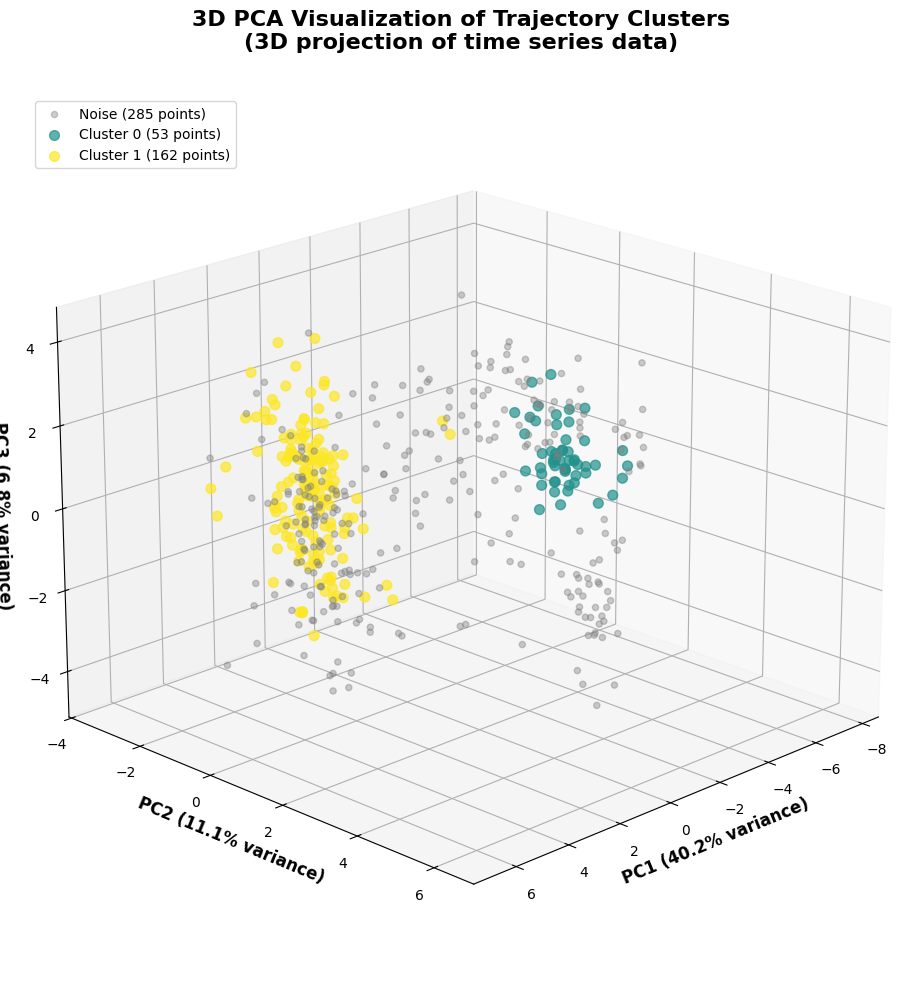


3D PCA Analysis Summary:
- Original dimensionality: 576 features
- Reduced to: 3 components
- Information preserved: 58.1%
- PC1 explains 40.2% of variance
- PC2 explains 11.1% of variance
- PC3 explains 6.8% of variance

Cluster Separation Analysis:
Cluster 0: Center=(-7.24, -0.55, -0.68), Spread=(0.29, 0.59, 0.77)
Cluster 1: Center=(2.49, -0.89, 0.32), Spread=(1.15, 0.77, 1.52)


In [26]:
# visualize clusters
plot_pca(X = X_sample, labels=clustering_results['labels'])

In [27]:
# Use original X_sample (not transposed) for plotting
sample_and_label = list(zip(X_sample, clustering_results['labels']))

# convert normalized back to lat/lon
lat_min, lat_max = 20, 60
lon_min, lon_max = -160, -60
max_sog = 30
max_cog = 360

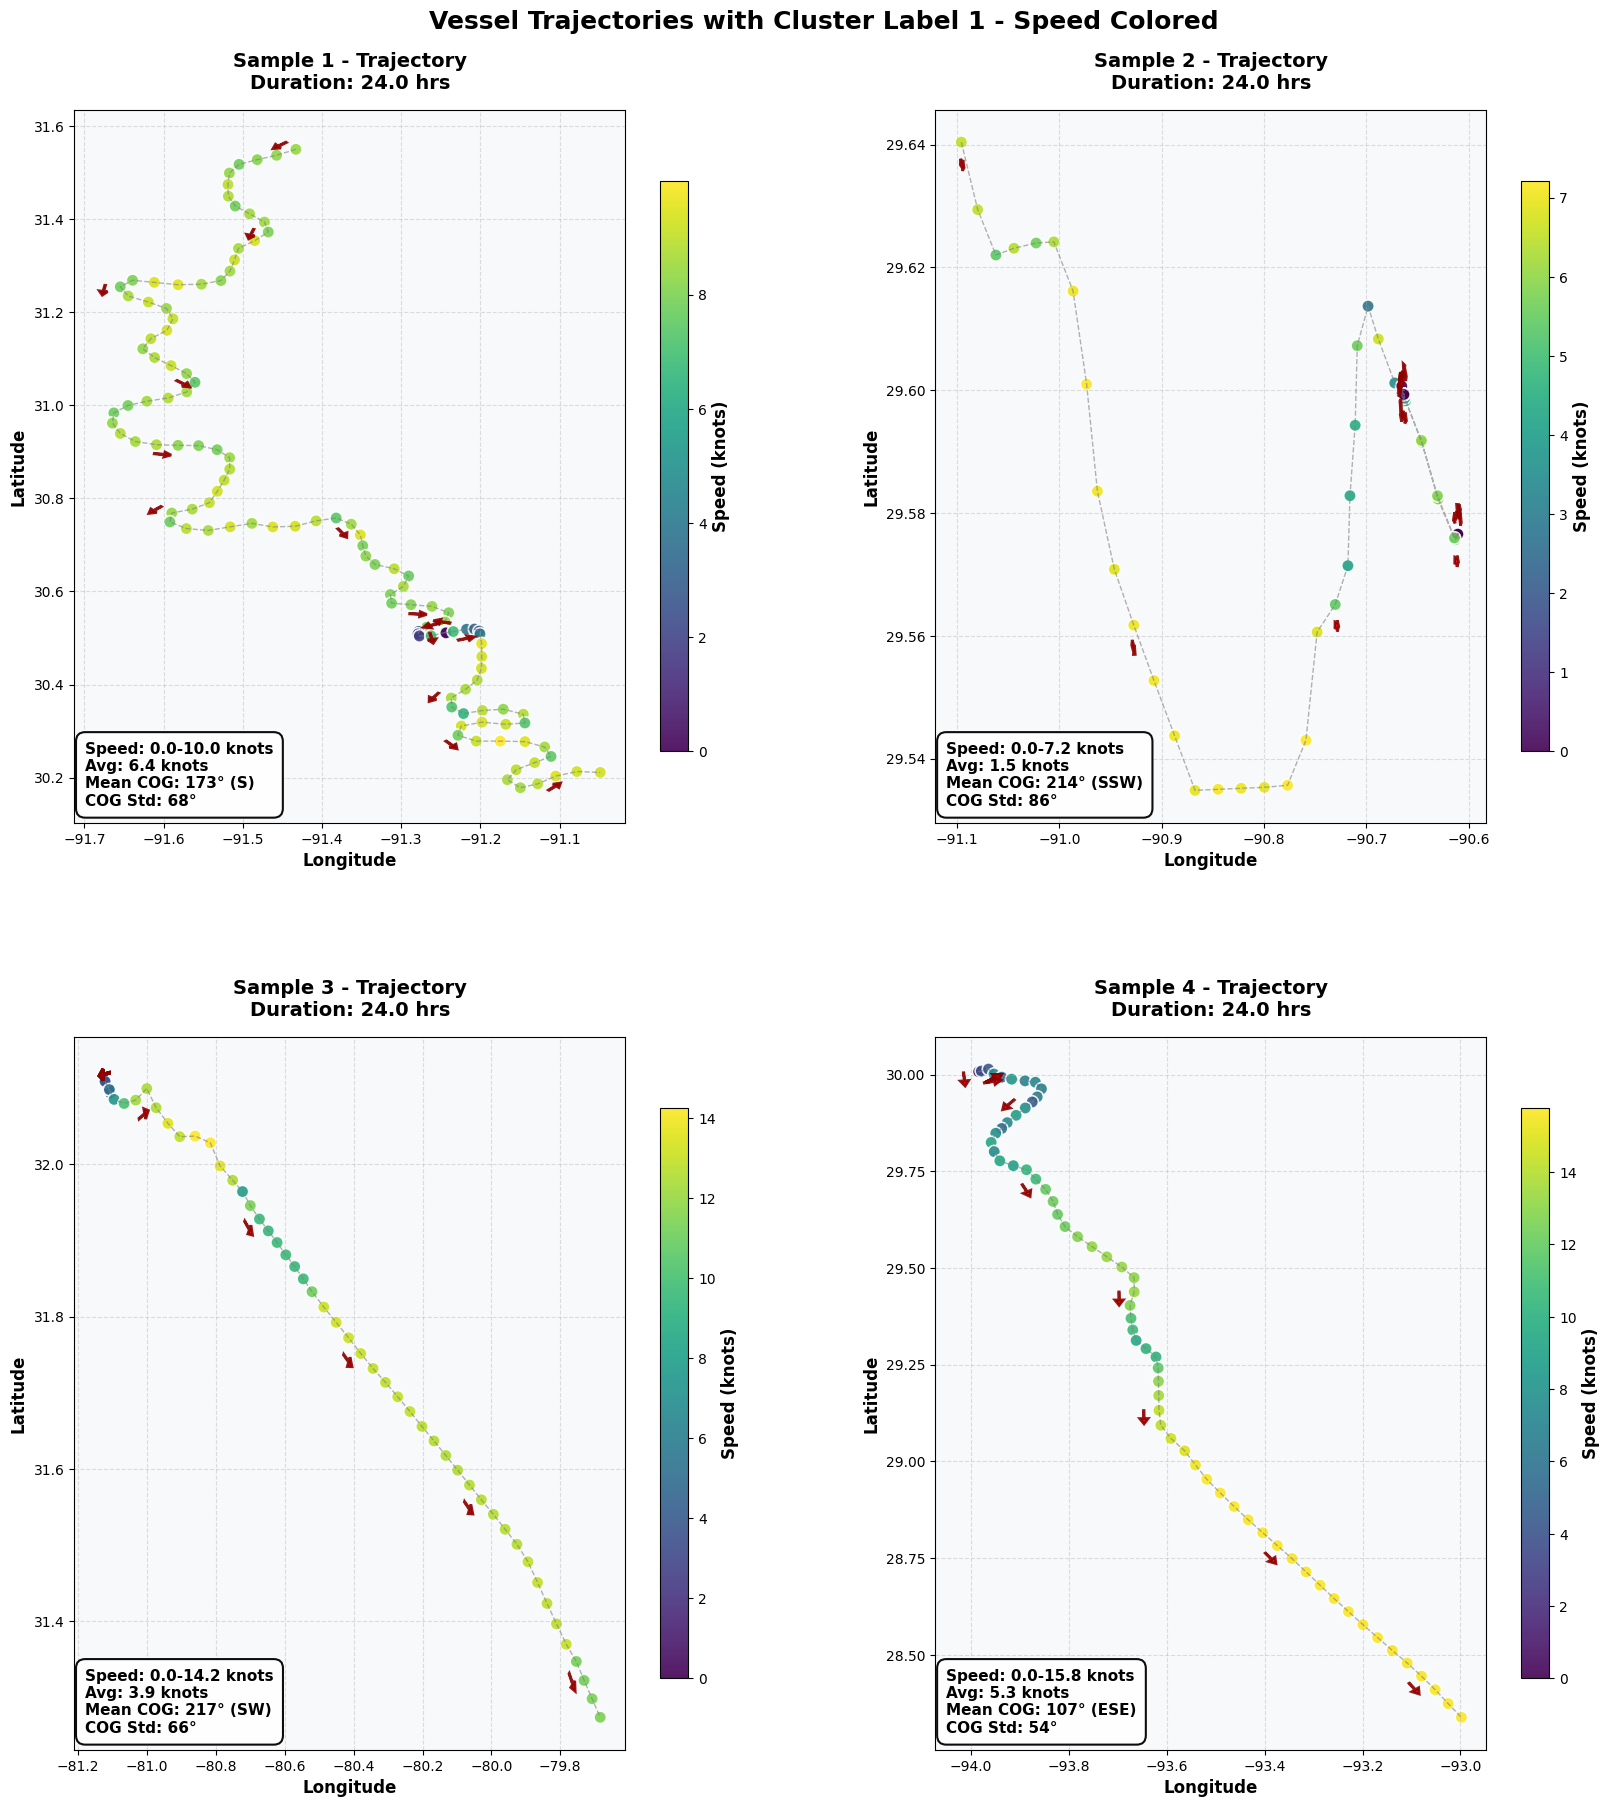

In [28]:

# filter samples with label
label = 1 # Change as needed
filtered_samples = [sample for sample, lbl in sample_and_label if lbl == label]
# len(filtered_samples)

filtered_samples_indexes_to_plot = (0, 12, 5, 8)

# Create subplots for trajectory plots with improved visibility
nols = 2
nrows = math.ceil(len(filtered_samples_indexes_to_plot) / nols)

fig, axes = plt.subplots(nrows, nols, figsize=(20, 20))
fig.suptitle(f'Vessel Trajectories with Cluster Label {label} - Speed Colored', fontsize=18, fontweight='bold', y=0.98)

# Flatten axes array for easy iteration
axes_flat = axes.flatten()

# plot 4 samples with label in subplots
for i, j in enumerate(filtered_samples_indexes_to_plot):
    # remove the padding (rows of zeros at the end)
    filtered_samples[j] = remove_trailing_padding(filtered_samples[j])
    # denormalize
    filtered_samples[j] = denormalize_coordinates(filtered_samples[j])
    
    # Extract coordinates, speed, and course
    longitudes = filtered_samples[j][:, 1]
    latitudes = filtered_samples[j][:, 0]
    speeds = filtered_samples[j][:, 2]  # Speed Over Ground (SOG)
    cog_degrees = filtered_samples[j][:, 3]  # Course Over Ground (COG)
    
    # Select the appropriate subplot
    ax = axes_flat[i]
    
    # Create scatter plot with colors based on speed - BACK TO ORIGINAL VIRIDIS
    scatter = ax.scatter(longitudes, latitudes, c=speeds, cmap='viridis', 
                        s=80, alpha=0.9, edgecolors='white', linewidth=1.2)
    
    # Connect points with lines to show trajectory - GRAY, THIN, DASHED
    ax.plot(longitudes, latitudes, color='gray', alpha=0.6, linewidth=1.0, linestyle='--')
    
    # Add course arrows to show direction - LARGER ARROWS
    add_course_arrows(ax, longitudes, latitudes, cog_degrees, spacing=10)
    
    # Add colorbar to show speed scale - LARGER TEXT
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Speed (knots)', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Improved grid and styling
    ax.grid(True, alpha=0.4, linewidth=0.8, linestyle='--')
    ax.set_facecolor('#f8f9fa')  # Light background
    
    # LARGER, BOLDER TITLES AND LABELS
    ax.set_title(f'Sample {i+1} - Trajectory\nDuration: {(10 * filtered_samples[j].shape[0]) / 60:.1f} hrs', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
    
    # Larger tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Find the best position for text box to avoid data overlap
    text_x, text_y, h_align, v_align = find_best_text_position(longitudes, latitudes)
    
    # Add speed and COG statistics with improved visibility
    speed_stats = f'Speed: {speeds.min():.1f}-{speeds.max():.1f} knots\nAvg: {speeds.mean():.1f} knots'
    cog_stats = add_cog_statistics_text(ax, cog_degrees, text_x, text_y, h_align, v_align)
    
    # IMPROVED TEXT BOX with better contrast and larger font
    ax.text(text_x, text_y, f'{speed_stats}\n{cog_stats}', 
            transform=ax.transAxes, fontsize=11, fontweight='bold',
            verticalalignment=v_align, horizontalalignment=h_align,
            bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.95, 
                     edgecolor='black', linewidth=1.5))

# Better spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.25, top=0.93)
plt.show()